In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tensorflow_addons.losses import PinballLoss
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus :
    try :
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e :
        print(e)

In [2]:
def GLU(inputs, n_units, use_timedistributed = False, dropout = None, activation = None) :
    
    if use_timedistributed :
        term_1 = keras.layers.TimeDistributed(keras.layers.Dense(n_units, activation = "sigmoid"))(inputs)
        term_2 = keras.layers.TimeDistributed(keras.layers.Dense(n_units, activation = activation))(inputs)
    
    else :
        term_1 = keras.layers.Dense(n_units, activation = "sigmoid")(inputs)
        term_2 = keras.layers.Dense(n_units, activation = activation)(inputs)
    
    outputs = keras.layers.Multiply()([term_1, term_2])
    
    if dropout is not None :
        outputs = keras.layers.Dropout(rate = dropout)(outputs)
        
    return outputs

def AddAndNorm(inputs, skip_connected) :
    Add = keras.layers.Add()([inputs, skip_connected])
    return keras.layers.LayerNormalization()(Add)

def GRN(inputs, n_units, context_vector = None, activation = None, dropout = None, use_timedistributed = False) :
    
    if not use_timedistributed :
        inputs_layer = keras.layers.Dense(n_units, activation = None)(inputs)
    
        if context_vector is not None :
            context_layer = keras.layers.Dense(n_units, activation = None, use_bias = False)(context_vector)
            elu_input = keras.layers.Add()([inputs_layer, context_layer])
        else :
            elu_input = inputs_layer
            
    else :
        inputs_layer = keras.layers.TimeDistributed(keras.layers.Dense(n_units, activation = None))(inputs)
    
        if context_vector is not None :
            context_layer = keras.layers.TimeDistributed(keras.layers.Dense(n_units, activation = None, use_bias = False))(context_vector)
            elu_input = keras.layers.Add()([inputs_layer, context_layer])
        else :
            elu_input = inputs_layer
        
    elu = keras.layers.Activation("elu")(elu_input)
    
    if not use_timedistributed :
        glu_inputs = keras.layers.Dense(n_units, activation = None)(elu)
    else :
        glu_inputs = keras.layers.TimeDistributed(keras.layers.Dense(n_units, activation = None))(elu)
    
    gated = GLU(glu_inputs, n_units, use_timedistributed, dropout, activation)
    
    norm = AddAndNorm(gated, inputs)
    
    return norm
    
def InputsToEmbedding(inputs, n_units, use_timedistributed = False):
    return keras.layers.TimeDistributed(keras.layers.Dense(n_units))(inputs)

def VariableSelectNetwork(timestep, n_features, n_units, batch_size, dropout = None, use_timedistributed = False) :
    inputs = keras.layers.Input(shape = (timestep, n_features), batch_size = batch_size)
    
    embeddings = []
    for i in range(n_features) :
        embeddings.append(InputsToEmbedding(inputs[:, :, i:i+1], n_units))
    
    embedding_flatten = keras.layers.Concatenate()(embeddings)
    variable_weight = keras.layers.Activation("softmax")(GRN(embedding_flatten, embedding_flatten.shape[2], use_timedistributed = use_timedistributed, dropout = dropout))
    
    GRN_embeddings = []
    
    for i in range(len(embeddings)) :
        GRN_embeddings.append(GRN(embeddings[i], n_units, use_timedistributed = use_timedistributed, dropout = dropout))
    
    multiplied = []
    for i in range(len(GRN_embeddings)) :
        multiplied.append(
            keras.layers.Multiply()([variable_weight[:, :, i : i+n_units], GRN_embeddings[i]])
        )
    
    VariableSelection = keras.layers.Add()(multiplied)
    VariableSelectionLayer = keras.models.Model(inputs = inputs, outputs = VariableSelection)
    
    return VariableSelectionLayer

def GatedLSTMLayer(input_model, n_units, cell_state = None, hidden_state = None, return_sequences = True) :
    target_layer = input_model.layers[-1].output
    LSTM = keras.layers.LSTM(n_units, return_sequences = return_sequences, recurrent_initializer = "glorot_normal", stateful = True)(target_layer)
    GatedLSTM = AddAndNorm(LSTM, target_layer)
    GatedLSTMModel = keras.models.Model(inputs = input_model.input, outputs = GatedLSTM)
    return GatedLSTMModel

def StaticEnrichment(input_model, n_units, context_vector = None, activation = None, dropout = None, use_timedistributed = False) :
    target_layer = input_model.layers[-1].output
    static_enrichment = GRN(target_layer, n_units, use_timedistributed = use_timedistributed, dropout = dropout)
    StaticEnrichmentLayer = keras.models.Model(inputs = input_model.input, outputs = static_enrichment)
    return StaticEnrichmentLayer

def TemporalSelfAttention(input_model, n_heads, n_units) :
    Key = input_model.layers[-1].output
    Query = input_model.layers[-1].output
    Value = input_model.layers[-1].output
    
    HeadList = []
    WeightedValue = keras.layers.Dense(n_units, activation = None, use_bias = False)(Value)
    
    for i in range(n_heads) :
        WeightedKey = keras.layers.Dense(n_units, activation = None, use_bias = False)(Key)
        WeightedKey = keras.layers.Permute((2, 1))(WeightedKey)
        WeightedQuery = keras.layers.Dense(n_units, activation = None, use_bias = False)(Query)
        
        Attention = keras.layers.Dot(axes = (2, 1))([WeightedQuery, WeightedKey])
        Attention = keras.layers.Lambda(lambda x : x * (1 / np.sqrt(WeightedQuery.shape[2])))(Attention)
        Attention = keras.layers.Activation("softmax")(Attention)
       
        HeadList.append(Attention)
    
    Sum = keras.layers.Add()(HeadList)    
    Mean = keras.layers.Lambda(lambda x : x * (1 / n_heads))(Sum)
    H = keras.layers.Dot(axes = (2, 1))([Mean, WeightedValue])
    MultiHeadAttention = keras.layers.Dense(n_units, activation = None, use_bias = False)(H)
    
    SkipConnected = AddAndNorm(MultiHeadAttention, Value)
    TemporalSelfAttentionLayer = keras.models.Model(inputs = input_model.input, outputs = SkipConnected)
    
    return TemporalSelfAttentionLayer

def PointwiseFeedFoward(input_model, skip_connection, n_units, use_timedistributed = False, dropout = None) :
    target_layer = input_model.layers[-1].output
    PWFF = GRN(target_layer, n_units, use_timedistributed = use_timedistributed, dropout = dropout)
    skip_connection_layer = skip_connection.layers[-1].output
    PWFF = GLU(PWFF, n_units, use_timedistributed = use_timedistributed, dropout = dropout)
    PWFFL = AddAndNorm(PWFF, skip_connection_layer)
    PWFFModel = keras.models.Model(inputs = input_model.input, outputs = PWFFL)
    return PWFFModel

def QuantileOutput(input_model, use_timedistributed = False) :
    target_layer = input_model.layers[-1].output
    
    if use_timedistributed :
        Output = keras.layers.TimeDistributed(keras.layers.Dense(1))(target_layer)
    else :
        Output = keras.layers.Dense(1)(target_layer)
        
    TFTModel = keras.models.Model(inputs = input_model.input, outputs = Output)
    return TFTModel

def TFTModel(time_step, n_feature, n_units, n_heads, batch_size, tau, dropout = None, use_timedistributed = False) :
    layer1 = VariableSelectNetwork(timestep = time_step, n_features = n_feature, n_units = n_units, batch_size = batch_size, use_timedistributed = use_timedistributed)
    layer2 = GatedLSTMLayer(layer1, n_units)
    layer3 = StaticEnrichment(layer2, n_units, use_timedistributed = use_timedistributed)
    layer4 = TemporalSelfAttention(layer3, n_heads, n_units)
    layer5 = PointwiseFeedFoward(layer4, layer2, n_units, use_timedistributed)
    model = QuantileOutput(layer5, use_timedistributed)
    
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.005)
    model.compile(optimizer = optimizer, loss = PinballLoss(tau = tau), metrics = ["mae"])
    return model

In [5]:
model = TFTModel(120, 33, 128, 30, 128, .5)

In [6]:
model.summary()

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(128, 120, 33)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_12 (T [(128, 120, 1)]      0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_13 (T [(128, 120, 1)]      0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_14 (T [(128, 120, 1)]      0           input_2[0][0]                    
______________________________________________________________________________________

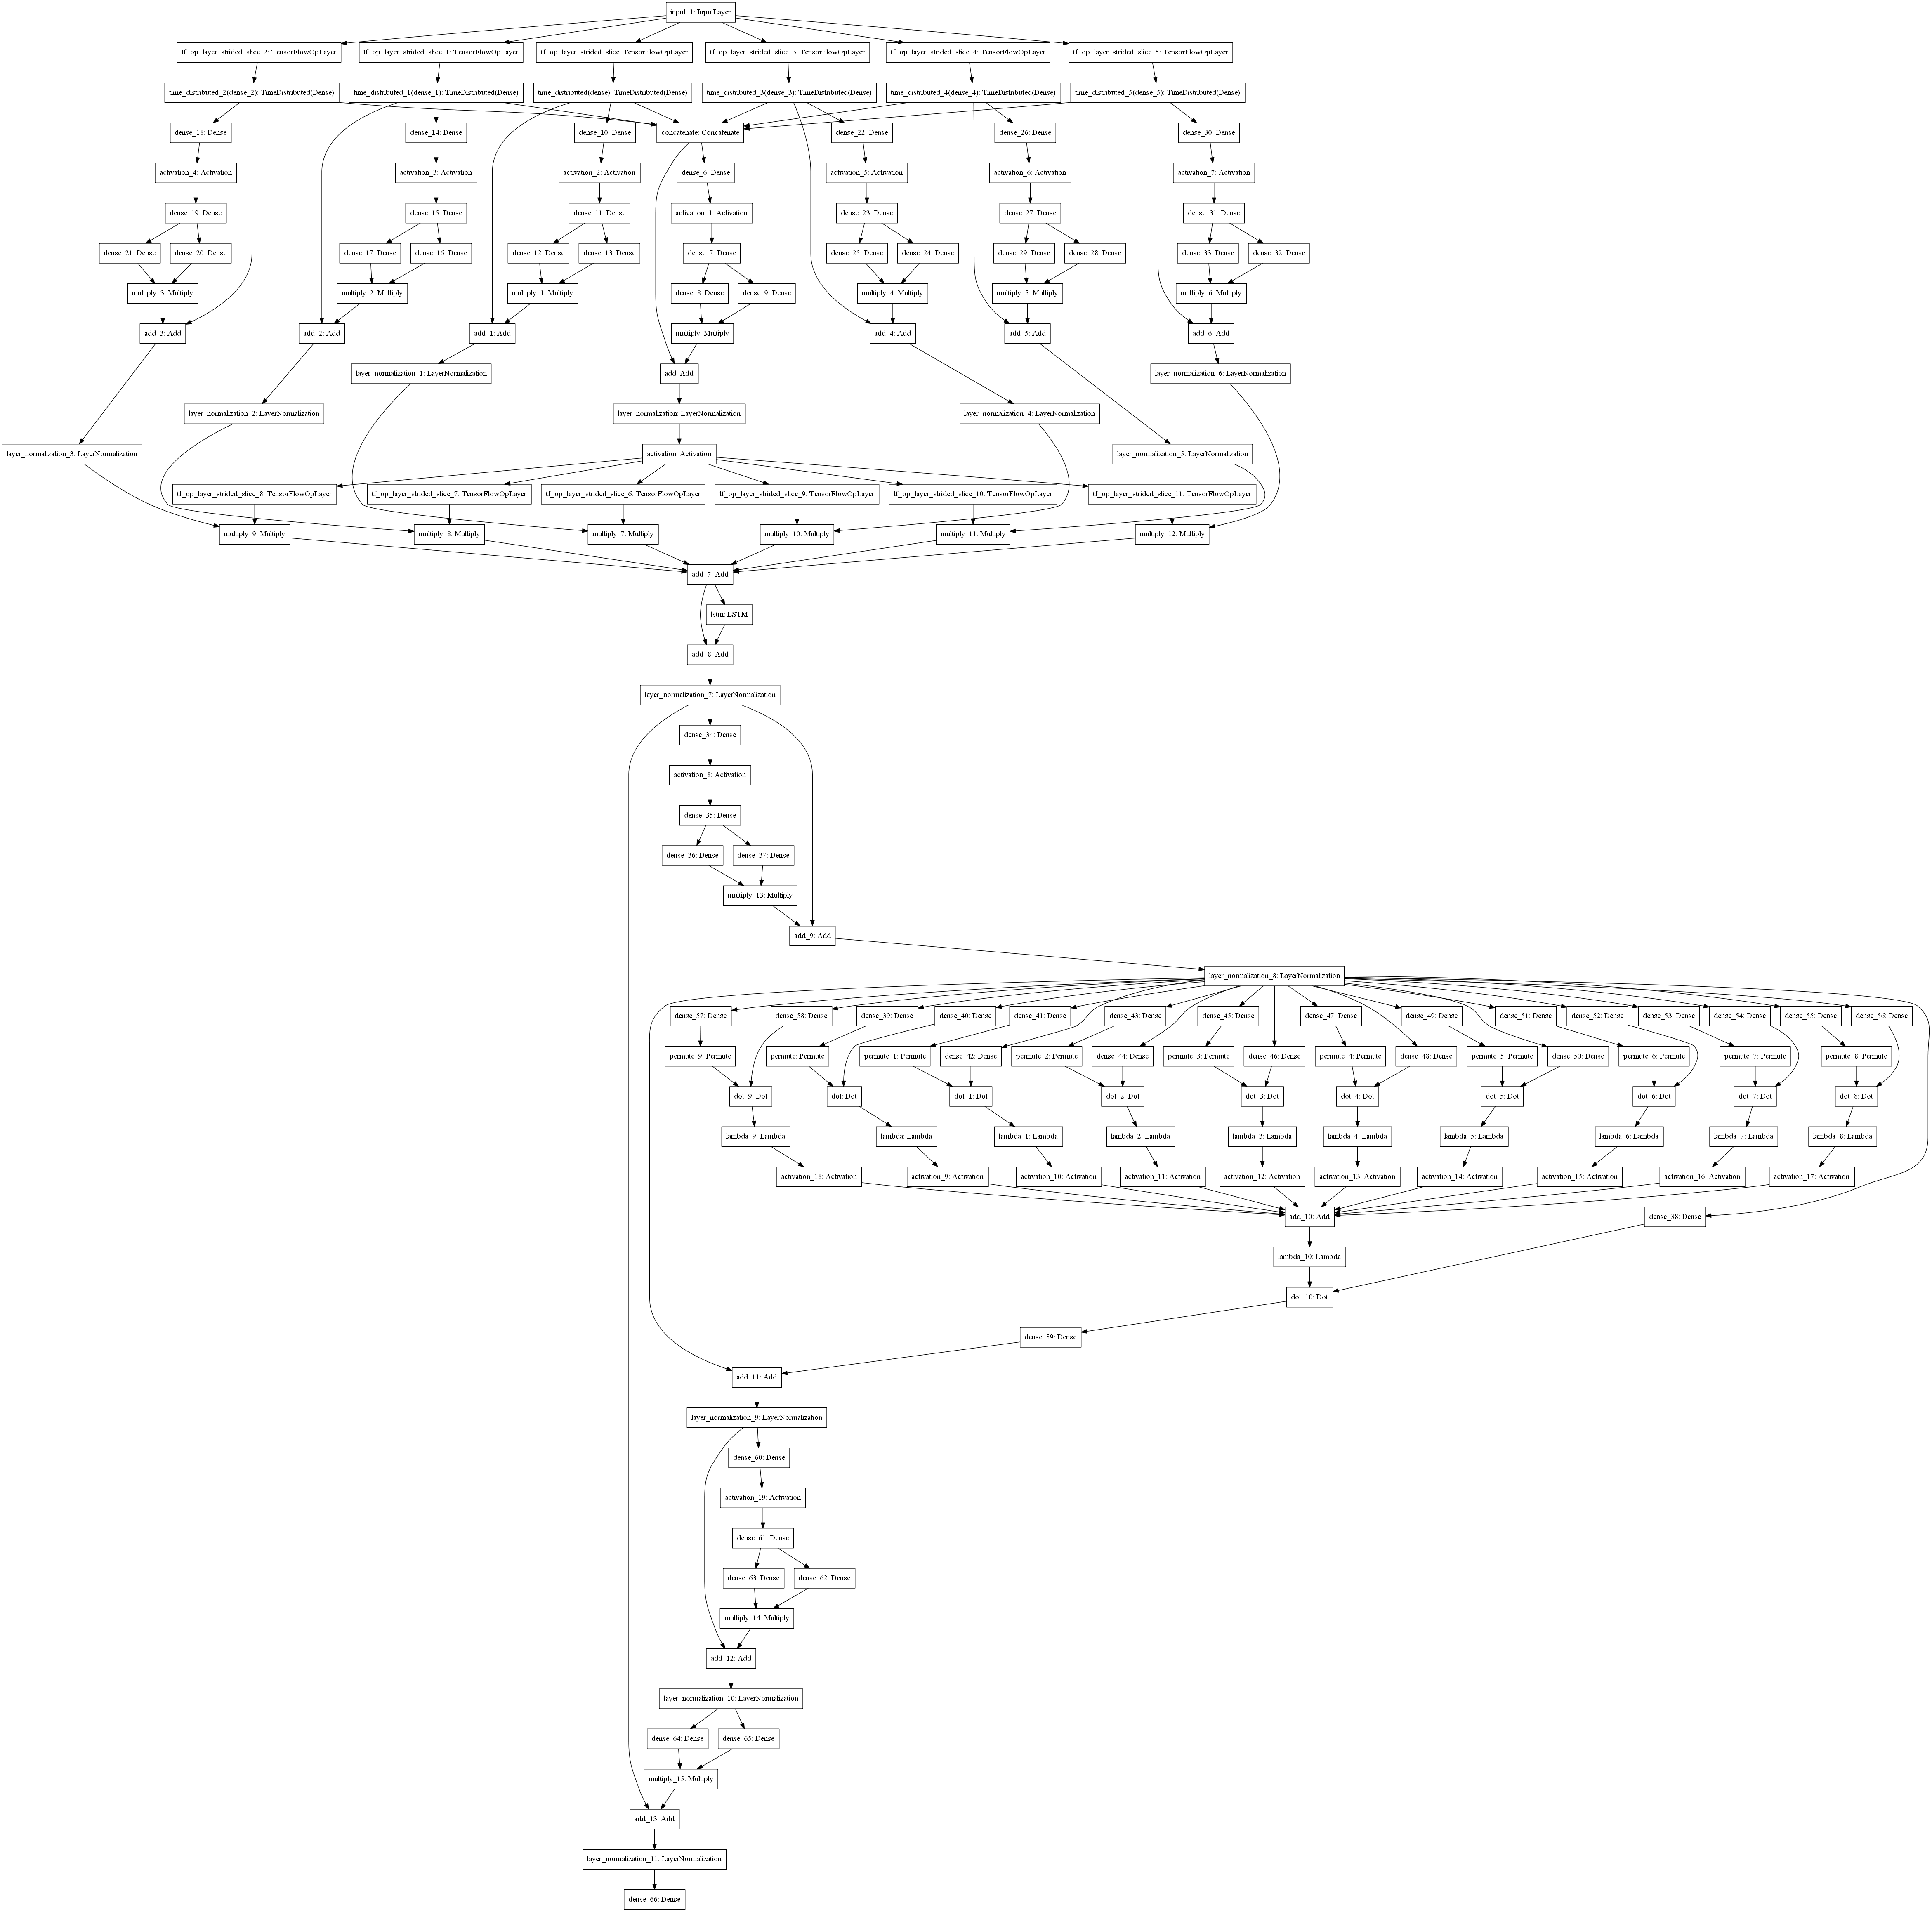

In [5]:
keras.utils.plot_model(model)

In [2]:
class DecimalScaler :
    def __init__(self) :
        self.dec = 0
        return
    
    def calculate(self, data) :
        return data / self.dec
    
    def fit(self, data) :
        self.dec = 10 ** np.array([len(i.split('.')[0]) for i in np.floor(data.max()).astype(str)])
        return
        
    def fit_transform(self, data) :
        self.fit(data)
        return self.calculate(data)
    
    def transform(self, data) :
        return self.calculate(data)
    
    def inverse_transform(self, data) :
        return data * self.dec

In [3]:
lookback = 48 * 2
interval = 1

def applyFeatureEngineering(data) :
    
    data.loc[:, "GHI"] = data["DHI"] + data["DNI"]
    data.loc[:, "DNI"] = np.log(data["DNI"] + 1)
    data.loc[:, "DHI"] = np.log(data["DHI"] + 1)
    data.loc[:, "WS"] = np.log(data["WS"] + 1)
    return data


train = pd.read_csv("./RawData/train/train.csv")
train = applyFeatureEngineering(train)

columnsIndex = np.array(range(train.columns.values.shape[0]))[np.isin(train.columns.values, ["TARGET", "DHI", "DNI", "RH", "WS", "T", "GHI"])]#, "GHI", "DHI_AVG", "DNI_AVG", "RH_AVG", "GHI_AVG", "WS_AVG", "TARGET_AVG"])]

trainFeature_2d = pd.DataFrame(train.iloc[:48 * 48 * 15, columnsIndex].reset_index(drop = True))
trainTarget_2d = train["TARGET"].iloc[:48 * 48 * 15]
trainTarget_2d = pd.DataFrame(trainTarget_2d.values.reshape(-1, 1), index = trainFeature_2d.index)

validFeature_2d = pd.DataFrame(train.iloc[48 * 48 * 15:, columnsIndex].reset_index(drop = True))
validTarget_2d = train["TARGET"].iloc[48 * 48 * 15:]
validTarget_2d = pd.DataFrame(validTarget_2d.values.reshape(-1, 1), index = validFeature_2d.index)


featureScaler = DecimalScaler()
targetScaler = DecimalScaler()

trainFeature_2d = pd.DataFrame(featureScaler.fit_transform(trainFeature_2d), index = trainFeature_2d.index)
trainTarget_2d = pd.DataFrame(targetScaler.fit_transform(trainTarget_2d), index = trainFeature_2d.index)

validFeature_2d = pd.DataFrame(featureScaler.transform(validFeature_2d), index = validFeature_2d.index)
validTarget_2d = pd.DataFrame(targetScaler.transform(validTarget_2d), index = validFeature_2d.index)


def makeTimeData(feature, target, timeStep, slideSize) :
    """
    timeStep  : How many "times" will LSTM look back? (Standard : 30 minutes)
                if timeStep value is 336, LSTM will predict target value with past 7 days
    slideSize : Period of standard in time series
    """
    
    newFeature = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, timeStep, feature.shape[1]))
    newTarget = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, 96, 1))
    #newTarget = np.empty(shape = ((feature.shape[0] - (timeStep + 96)) // slideSize, 96))

    for i in range(newFeature.shape[0]) :
        newFeature[i] = feature.iloc[(i * slideSize) : (i * slideSize) + timeStep, :]
        newTarget[i] = target.iloc[(i * slideSize) + timeStep : (i * slideSize) + timeStep + 96]#.values.reshape(-1)

    newFeature = tf.convert_to_tensor(newFeature)
    newTarget = tf.convert_to_tensor(newTarget)
        
    return newFeature, newTarget

trainFeature, trainTarget = makeTimeData(trainFeature_2d, trainTarget_2d, lookback, interval)
validFeature, validTarget = makeTimeData(validFeature_2d, validTarget_2d, lookback, interval)


In [10]:
batch_size = 256
es = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0.0001, patience = 30, restore_best_weights = True)
#lr = keras.callbacks.LearningRateScheduler(schedule = keras.experimental.CosineDecay(initial_learning_rate = 0.005, decay_steps = 30, alpha = 1e-8))
lr = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.log10(3), patience = 10, verbose = 1, min_delta = 0.0005)


modelList = {}
for i in range(5, 6) :
    modelList[str(np.round(i * .1, decimals = 1))] = TFTModel(time_step = trainFeature.shape[1], n_feature = trainFeature.shape[2], n_units =  7,
                                                              n_heads = 23, batch_size = batch_size, tau = np.round(i * .1, decimals = 1), use_timedistributed = True, dropout = 0.0)
    print("Tau : " + str(np.round(i * .1, decimals = 1)))
    modelList[str(np.round(i * .1, decimals = 1))].fit(trainFeature[:-(trainFeature.shape[0] % batch_size)], trainTarget[:-(trainFeature.shape[0] % batch_size)], epochs = 200, shuffle = False,
                                                       validation_data = (validFeature[:-(validFeature.shape[0] % batch_size)], validTarget[:-(validFeature.shape[0] % batch_size)]), batch_size = batch_size, callbacks = [lr, es])

Tau : 0.5
Epoch 1/200
134/134 [==============================] - 19s 142ms/step - loss: 0.2011 - mae: 0.4021 - val_loss: 0.0455 - val_mae: 0.0910
Epoch 2/200
110/134 [=======================>......] - ETA: 2s - loss: 0.0428 - mae: 0.0856

KeyboardInterrupt: 

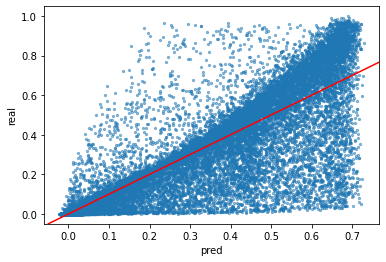

In [71]:
result = modelList["0.5"].predict(trainFeature[:-(trainFeature.shape[0] % batch_size)], batch_size = batch_size)
plotResult_5 = result[np.arange(result.shape[0]) % (lookback // interval) == 0].reshape(-1)
plotReal = trainTarget[np.arange(trainTarget.shape[0]) % (lookback // interval) == 0].numpy().reshape(-1)
plotResult_5.shape
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")

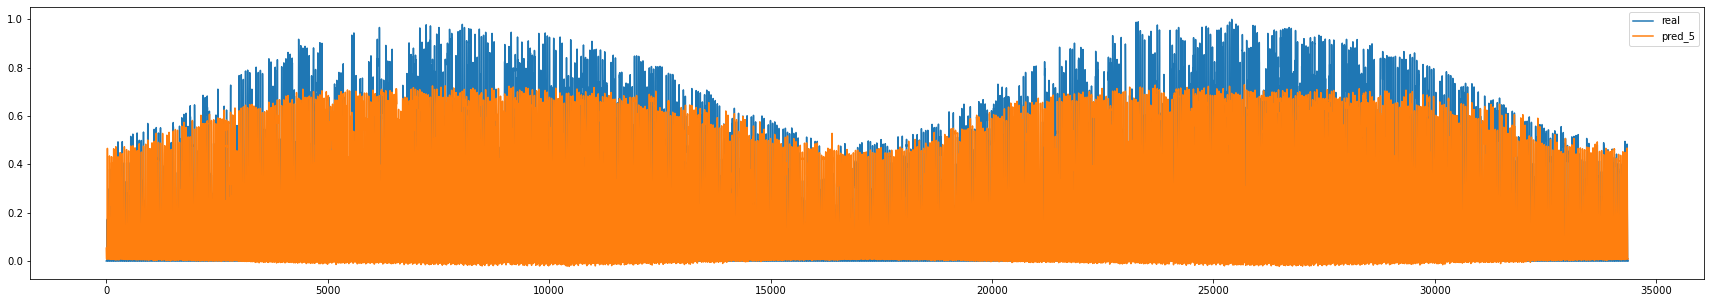

In [72]:
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8"

#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()

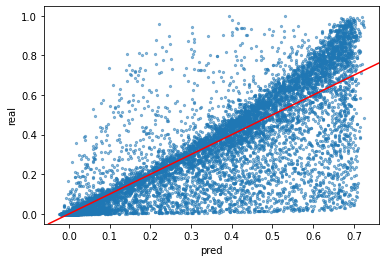

In [69]:
result = modelList["0.5"].predict(validFeature[:-(validFeature.shape[0] % batch_size)], batch_size = batch_size)
plotResult_5 = result[np.arange(result.shape[0]) % (lookback // interval) == 0].reshape(-1)
plotReal = validTarget[np.arange(validTarget.shape[0]) % (lookback // interval) == 0].numpy().reshape(-1)[:-(validFeature.shape[0] % batch_size) - 48]
plotResult_5.shape
plt.scatter(plotResult_5, plotReal, alpha = .5, s = 5)
plt.xlabel("pred")
plt.ylabel("real")
plt.axline((0, 0), slope = 1, c = "red")

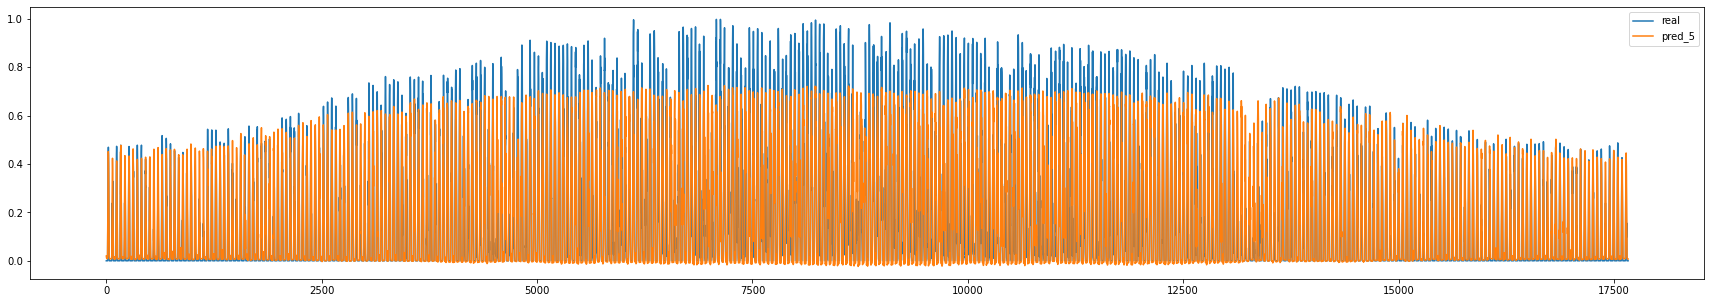

In [70]:
start = 0
end = 730
plt.figure(figsize = (30, 5))
plt.plot(plotReal[48 * start :48 * end], label = "real")
#plt.plot(plotResult_1[: 48 * days], label = "pred_1")
#plt.plot(plotResult_2[: 48 * days], label = "pred_2")
#plt.plot(plotResult_3[: 48 * days], label = "pred_3")
#plt.plot(plotResult_4[: 48 * days], label = "pred_4")
plt.plot(plotResult_5[48 * start: 48 * end], label = "pred_5")
#plt.plot(plotResult_6[: 48 * days], label = "pred_6")
#plt.plot(plotResult_7[: 48 * days], label = "pred_7")
#plt.plot(plotResult_8[: 48 * days], label = "pred_8")
#plt.plot(plotResult_9[48 * start: 48 * end], label = "pred_9")
plt.legend()